# Similarities between Pokemon types

Work in progress, but hopefully will be finished soon!

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO


## Dowloading type-matchup table

In [2]:
# using request so I won't get blocked by website

table_url = 'https://pokemondb.net/type'
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'

req = urllib.request.Request(table_url, headers={'User-Agent': user_agent})

with urllib.request.urlopen(req) as response:
    html = response.read().decode('utf-8')

df_list = pd.read_html(StringIO(html))

print(f"Count of tables on that site: {len(df_list)}")


Count of tables on that site: 1


In [3]:
df = df_list[0]
df.head()

,DEFENSE → ATTACK ↴,Nor,Fir,Wat,Ele,Gra,Ice,Fig,Poi,Gro,Fly,Psy,Bug,Roc,Gho,Dra,Dar,Ste,Fai
0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,½,0,NaN,NaN,½,NaN
1,Fire,NaN,½,½,NaN,2,2,NaN,NaN,NaN,NaN,NaN,2,½,NaN,½,NaN,2,NaN
2,Water,NaN,2,½,NaN,½,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,½,NaN,NaN,NaN
3,Electric,NaN,NaN,2,½,½,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,½,NaN,NaN,NaN
4,Grass,NaN,½,2,NaN,½,NaN,NaN,½,2,½,NaN,½,2,NaN,½,NaN,½,NaN


# Cleaning up table

In [4]:
old_name = df.columns[0]
df.rename(columns={old_name: 'Attack'}, inplace=True)
df.set_index('Attack', inplace=True)

In [5]:
# rename column names so they match rows

df.columns = df.index.tolist()
df.head()

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Attack,,,,,,,,,,,,,,,,,,
Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,½,0,NaN,NaN,½,NaN
Fire,NaN,½,½,NaN,2,2,NaN,NaN,NaN,NaN,NaN,2,½,NaN,½,NaN,2,NaN
Water,NaN,2,½,NaN,½,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,½,NaN,NaN,NaN
Electric,NaN,NaN,2,½,½,NaN,NaN,NaN,0,2,NaN,NaN,NaN,NaN,½,NaN,NaN,NaN
Grass,NaN,½,2,NaN,½,NaN,NaN,½,2,½,NaN,½,2,NaN,½,NaN,½,NaN


In [6]:
# empty space in table meant regular effectiveness, which is 1 multiplier
df.replace(np.NaN, 1, inplace=True)
print(df)

          Normal Fire Water Electric Grass Ice Fighting Poison Ground Flying  \
Attack                                                                         
Normal       1.0    1     1        1     1   1        1      1      1      1   
Fire         1.0    ½     ½        1     2   2        1      1      1      1   
Water        1.0    2     ½        1     ½   1        1      1      2      1   
Electric     1.0    1     2        ½     ½   1        1      1      0      2   
Grass        1.0    ½     2        1     ½   1        1      ½      2      ½   
Ice          1.0    ½     ½        1     2   ½        1      1      2      2   
Fighting     2.0    1     1        1     1   2        1      ½      1      ½   
Poison       1.0    1     1        1     2   1        1      ½      ½      1   
Ground       1.0    2     1        2     ½   1        1      2      1      0   
Flying       1.0    1     1        ½     2   1        2      1      1      1   
Psychic      1.0    1     1        1    

In [7]:
# that fraction is annoying, so let's change that to 0.5

# get that string from table
fraction_string = df['Rock']['Normal']

In [8]:
# addressing like that (defending type first and then attacking) is counterintuitive,
# let's transpose the frame

df = df.transpose()
df.head()

Attack,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Fire,1,½,2,1,½,½,1,1,2,1,1,½,2,1,1,1,½,½
Water,1,½,½,2,2,½,1,1,1,1,1,1,1,1,1,1,½,1
Electric,1,1,1,½,1,1,1,1,2,½,1,1,1,1,1,1,½,1
Grass,1,2,½,½,½,2,1,2,½,2,1,2,1,1,1,1,1,1


In [9]:
# this seems much better
fraction_string = df['Normal']['Rock']
print(fraction_string)

½


In [10]:
df.replace(fraction_string, 0.5, inplace=True)

In [11]:
df.head()

Attack,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Fire,1,0.5,2,1,0.5,0.5,1,1,2,1,1,0.5,2,1,1,1,0.5,0.5
Water,1,0.5,0.5,2,2,0.5,1,1,1,1,1,1,1,1,1,1,0.5,1
Electric,1,1,1,0.5,1,1,1,1,2,0.5,1,1,1,1,1,1,0.5,1
Grass,1,2,0.5,0.5,0.5,2,1,2,0.5,2,1,2,1,1,1,1,1,1


In [12]:
df.dtypes

,0
Attack,
Normal,object
Fire,object
Water,object
Electric,object
Grass,object
Ice,object
Fighting,object
Poison,object
Ground,object


In [13]:
#lets change everything to float
df = df.astype('float64')

df.head()

Attack,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Normal,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Fire,1.0,0.5,2.0,1.0,0.5,0.5,1.0,1.0,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5
Water,1.0,0.5,0.5,2.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
Electric,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0
Grass,1.0,2.0,0.5,0.5,0.5,2.0,1.0,2.0,0.5,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


# Measuring the similarity between types

In [14]:
from scipy.spatial import distance

In [15]:
fire = df['Fire']
flying = df['Flying']

#euklidean distance
distance.euclidean(fire, flying)

2.29128784747792

In [16]:
#Manhattan distance

distance.cityblock(fire, flying)

5.5

In [17]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([fire], [flying])[0][0])

def cosine_similarity_wrapper(list1: list, list2: list) -> float:
  return cosine_similarity([list1], [list2])[0][0]

0.8994012224377721


In [18]:
# jaccard similarity

def jaccard_similarity(list1: list, list2: list)-> float:
  s1 = set(list1)
  s2 = set(list2)
  return float(len(s1&s2) / len(s1|s2)) #intercesction, union


In [19]:
jaccard_similarity(fire, flying)

1.0

In [20]:
#pearson correlation coefficient
from scipy.stats import pearsonr

pearson_coef, p_value = pearsonr(fire, flying)

print(pearson_coef, p_value)

0.38045682244505474 0.11935005909330973


# Comparing every type offensively

In [21]:
from itertools import combinations_with_replacement
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
from collections.abc import Callable

InputFunction = Callable[[list, list], float]

def calculate_and_plot(function: InputFunction, df: pd.DataFrame, title: str) -> pd.DataFrame:
  types_count = len(df.columns)
  df_values = pd.DataFrame().reindex_like(df) # copy structure
  every_combo = list(combinations_with_replacement(df.columns, 2))

  for type1, type2 in every_combo:
    val = function(df[type1], df[type2])
    df_values.loc[type1, type2] = val
    df_values.loc[type2, type1] = val

  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(df_values, annot=True, ax=ax)
  plt.title(title)
  plt.show()

  return df_values

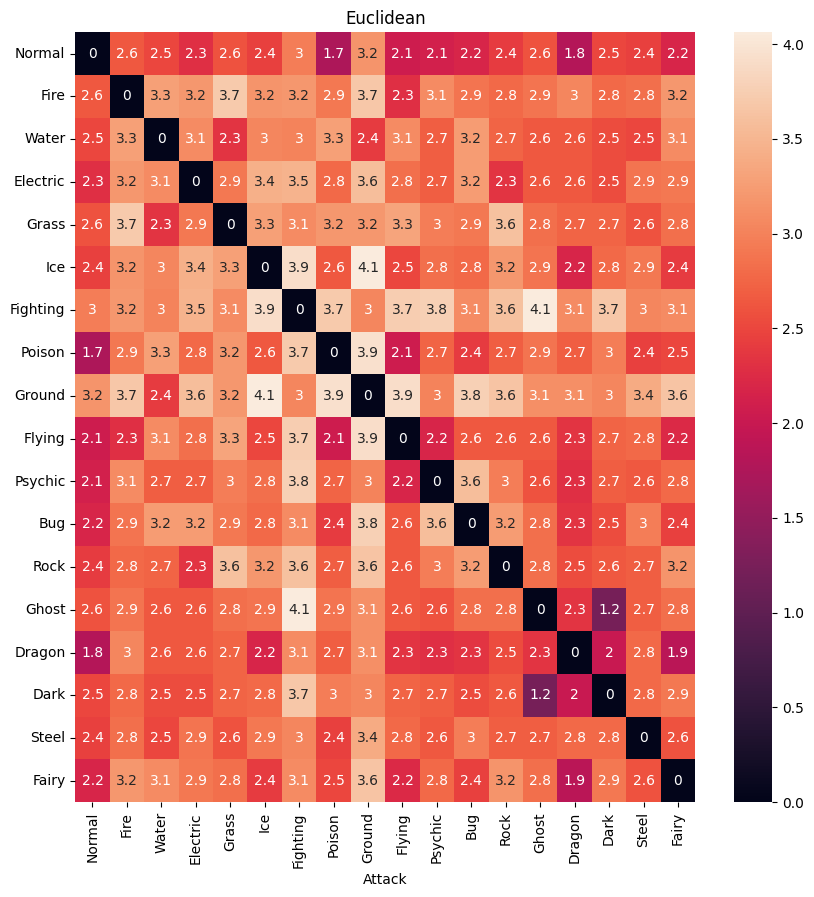

In [96]:
euclidean_off = calculate_and_plot(distance.euclidean, df, "Euclidean")

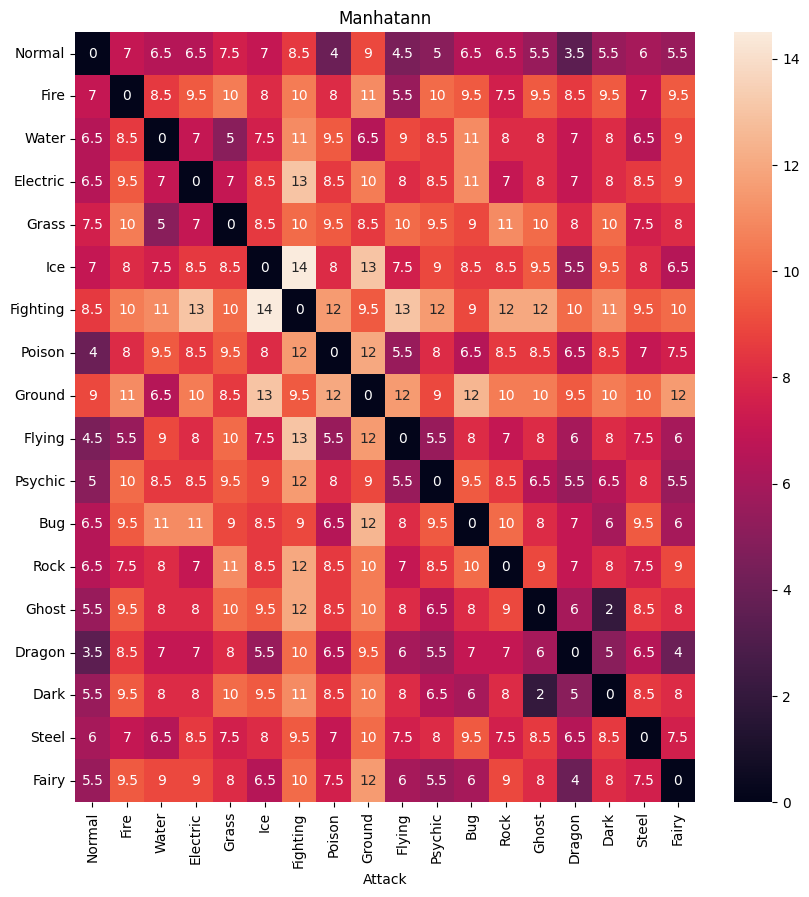

In [97]:
manhattan_off = calculate_and_plot(distance.cityblock, df, "Manhatann")

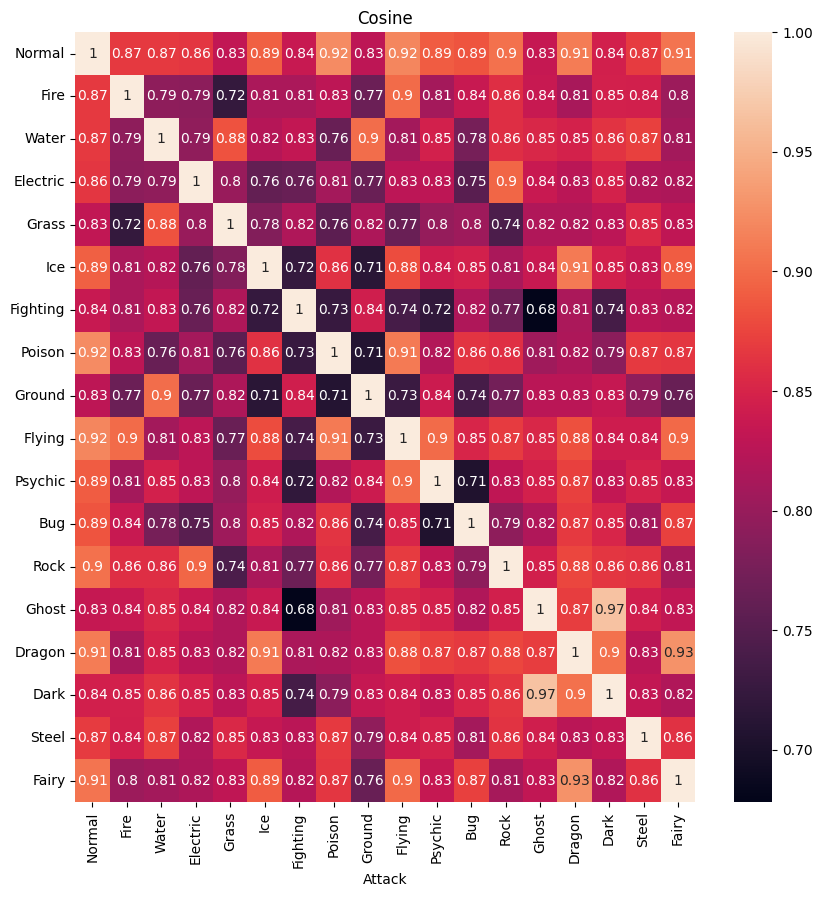

In [98]:
cosine_off = calculate_and_plot(cosine_similarity_wrapper, df, "Cosine")

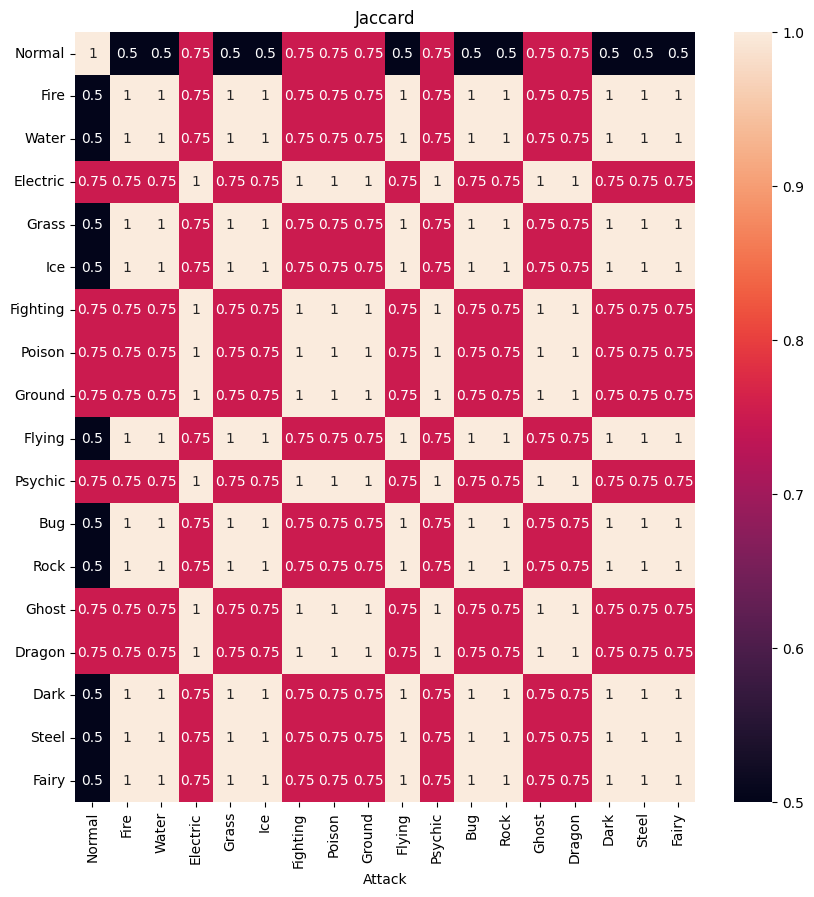

In [99]:
jaccard_off = calculate_and_plot(jaccard_similarity, df, "Jaccard")

## Pearson and P-values

In [100]:
def calculate_pearson(df: pd.DataFrame, title: str) -> pd.DataFrame:
  types_count = len(df.columns)
  df_values = pd.DataFrame().reindex_like(df) # copy structure
  df_pvalues = pd.DataFrame().reindex_like(df)
  every_combo = list(combinations_with_replacement(df.columns, 2))

  for type1, type2 in every_combo:
    pearson_coef, p_value = pearsonr(df[type1], df[type2])
    df_values.loc[type1, type2] = pearson_coef
    df_values.loc[type2, type1] = pearson_coef
    df_pvalues.loc[type1, type2] = p_value
    df_pvalues.loc[type2, type1] = p_value

  #convert p_values to categories
  categories = ["Strong", "Moderate", "Weak", "Uncertain"]
  cuts = [0.0, 0.001, 0.05, 0.1, 10]
  df_pvalues = pd.cut(df_pvalues.stack(), cuts, labels=categories)
  df_pvalues = df_pvalues.unstack()
  # apparently there is an issue with cut returning nan sometimes
  # best thing i can do for now is replace them with uncertain (since I don't know what supposed to be there)

  df_pvalues.fillna("Uncertain", inplace=True)

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

  sns.heatmap(df_values, annot=True, ax=ax1, fmt='.2f', annot_kws={"size": 6})
  ax1.title.set_text("Pearson Correlation Values")

  categories.reverse()
  value_to_int = {j:i for i,j in enumerate(categories)}
  n = len(value_to_int)
  print(value_to_int)

  # discrete colormap (n samples from a given cmap)
  cmap = sns.color_palette("tab10", n)
  with pd.option_context("future.no_silent_downcasting", True):
    replaced = df_pvalues.replace(value_to_int).astype('int64')
  sns.heatmap(replaced, cmap=cmap, ax=ax2)

  colorbar = ax2.collections[0].colorbar
  r = colorbar.vmax - colorbar.vmin
  colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
  colorbar.set_ticklabels(list(value_to_int.keys()))
  ax2.title.set_text("P-values categories")
  plt.show()

  return df_values

{'Uncertain': 0, 'Weak': 1, 'Moderate': 2, 'Strong': 3}


<ipython-input-100-81ad63cb1569>:37: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  replaced = df_pvalues.replace(value_to_int).astype('int64')


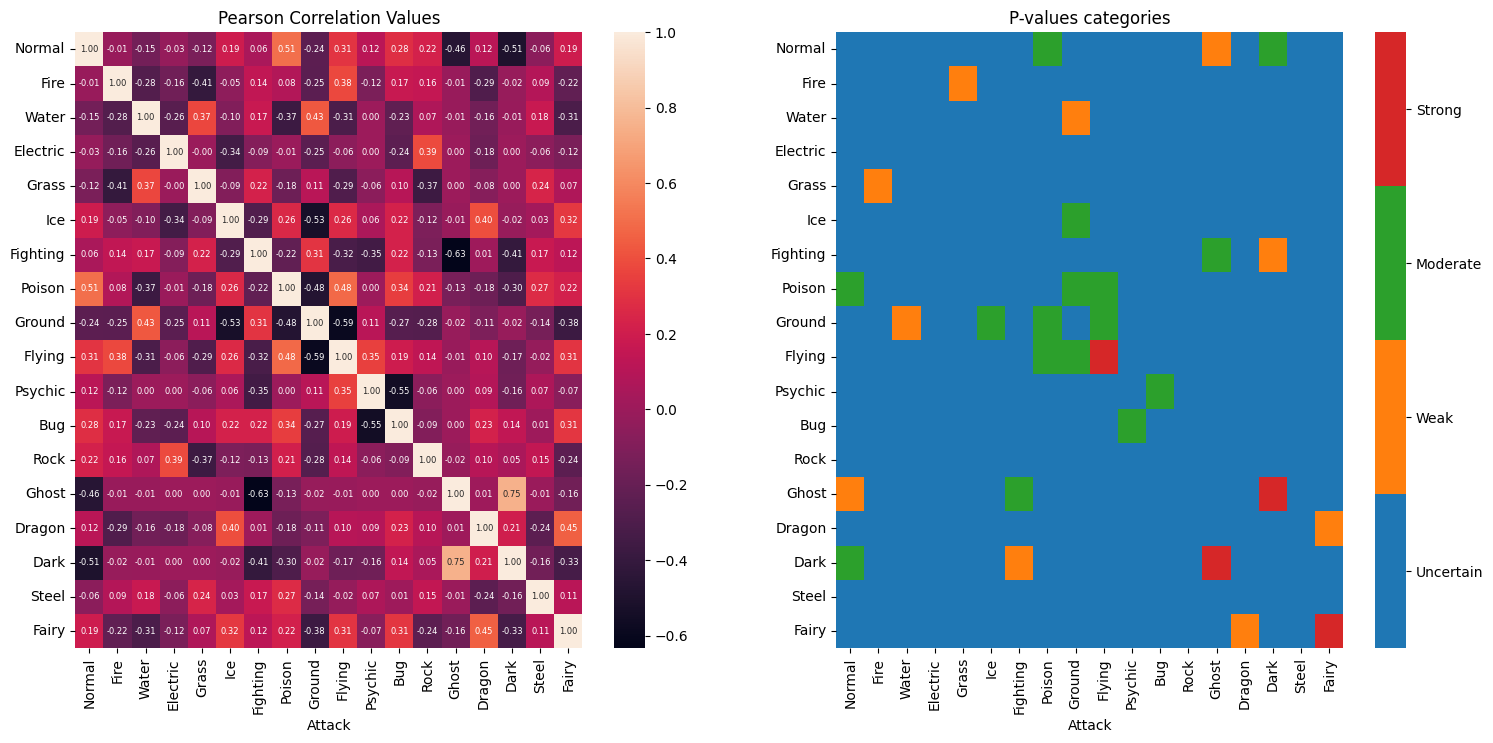

In [101]:
pearson_off = calculate_pearson(df, "Pearson")

## Defensive similarities

In [102]:
df_def = df.transpose(copy=True)
df_def.rename_axis('Defence', inplace=True)

df_def.head()

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
Defence,,,,,,,,,,,,,,,,,,
Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
Fire,1.0,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
Water,1.0,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
Electric,1.0,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
Grass,1.0,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0


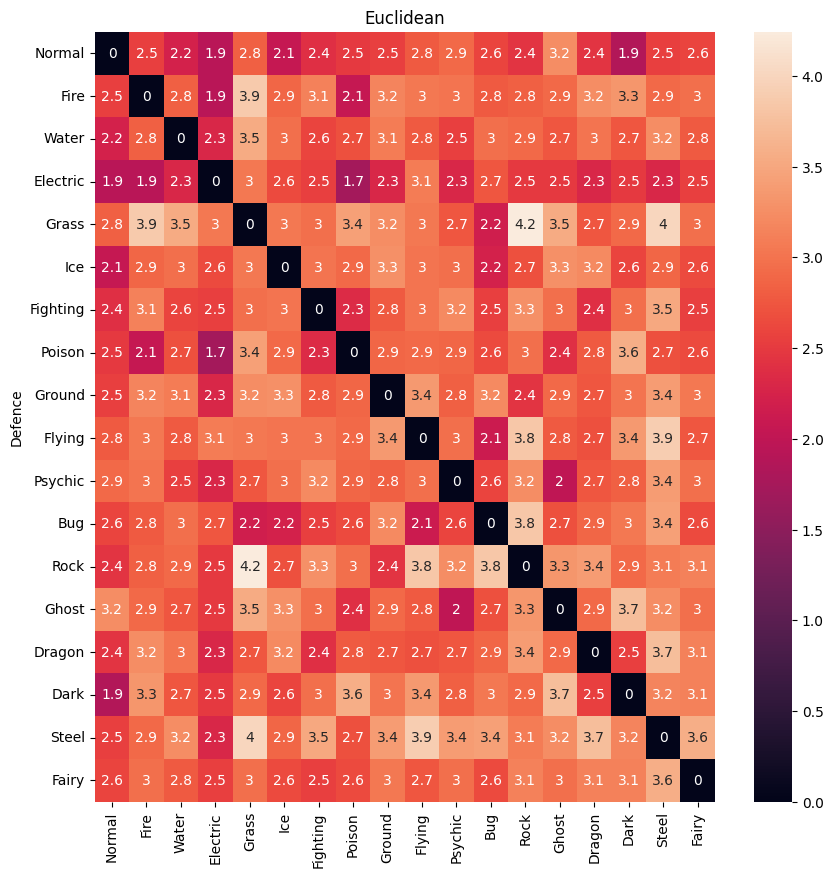

In [103]:
euclidean_def = calculate_and_plot(distance.euclidean, df_def, "Euclidean")

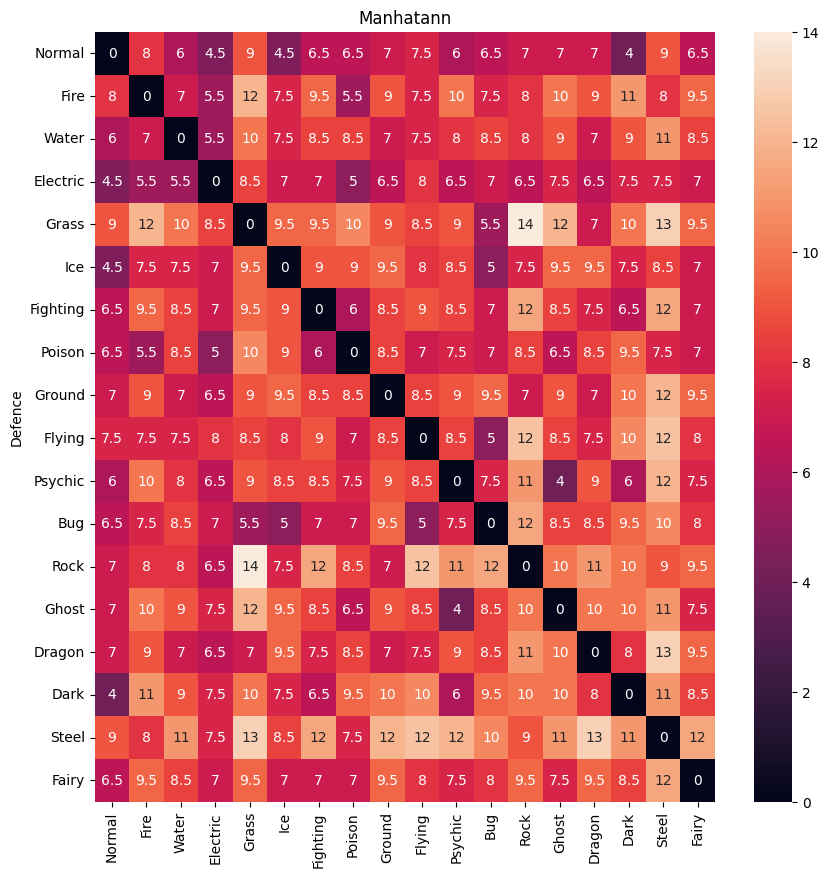

In [104]:
manhattan_def = calculate_and_plot(distance.cityblock, df_def, "Manhatann")

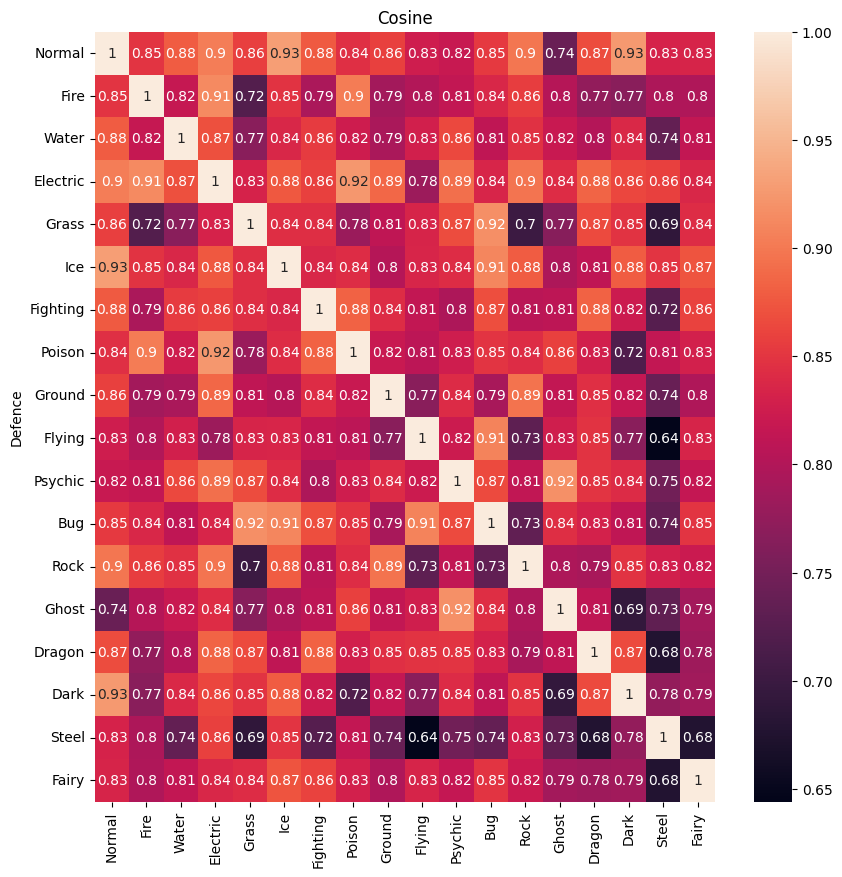

In [105]:
cosine_def = calculate_and_plot(cosine_similarity_wrapper, df_def, "Cosine")

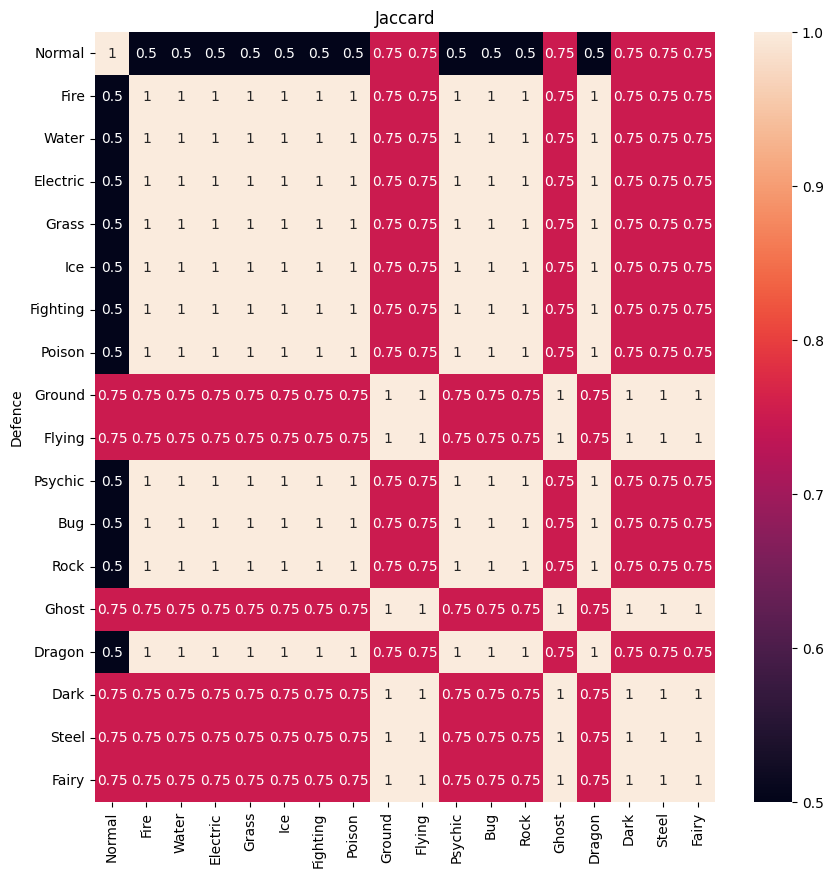

In [106]:
jaccard_def = calculate_and_plot(jaccard_similarity, df_def, "Jaccard")

{'Uncertain': 0, 'Weak': 1, 'Moderate': 2, 'Strong': 3}


<ipython-input-100-81ad63cb1569>:37: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  replaced = df_pvalues.replace(value_to_int).astype('int64')


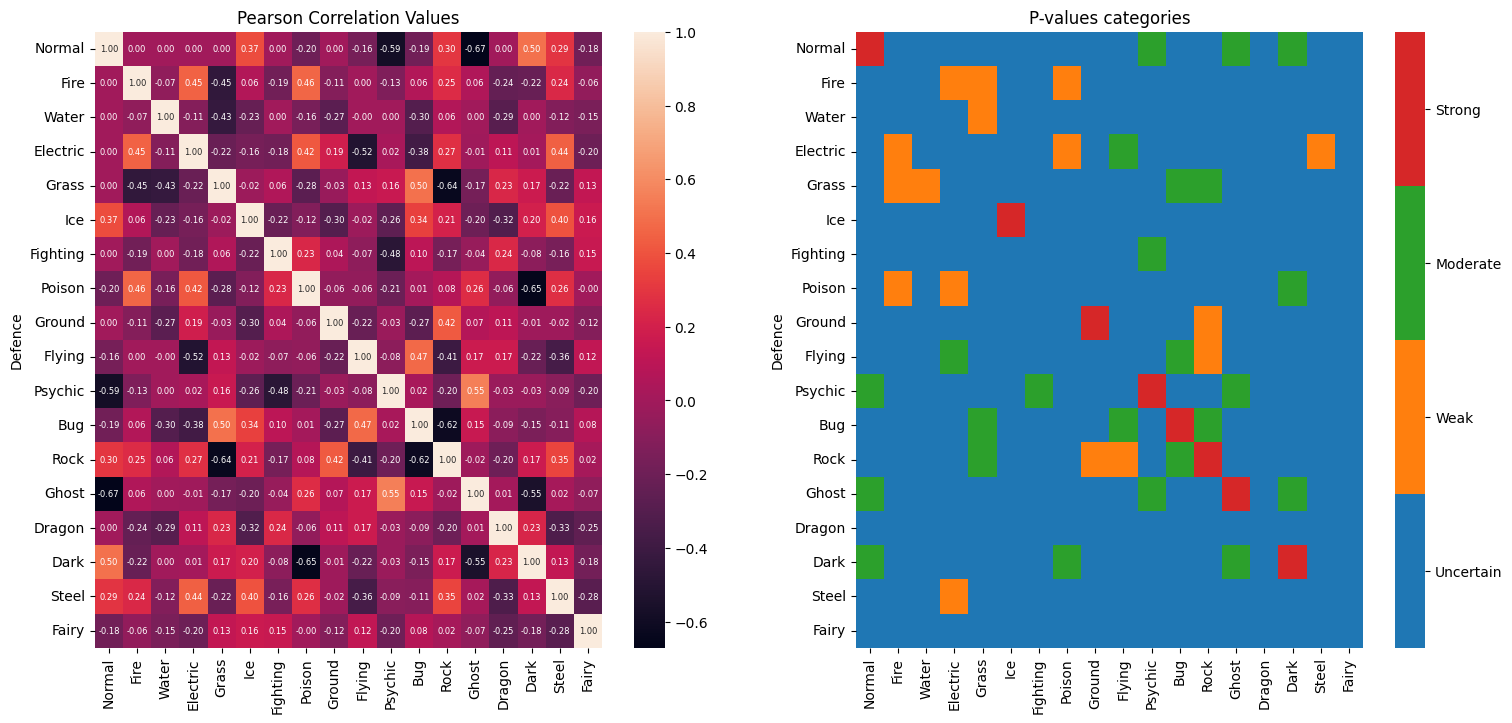

In [107]:
pearson_def = calculate_pearson(df_def, "Pearson")

# Summary Table

In [123]:
type_one = 'Fire'
type_two = 'Flying'

summary_columns = ['Attack', f'Attack Rank for {type_one}', f'Attack Rank for {type_two}',
                   'Defense', f'Defense Rank for {type_one}', f'Defense Rank for {type_two}']

summary_rows = ['Euclidean Distance', 'Manhattan Distance', 'Cosine Similarity', 'Jaccard Similarity', 'Pearson Correlation']

df_summary = pd.DataFrame(0, index=summary_rows, columns=summary_columns)


# Optionally, fill it with NaN (default behavior)
df_summary = df_summary.astype(int)
df_summary[['Attack', 'Defense']] = df_summary[['Attack', 'Defense']].astype(float)

df_summary.head()

,Attack,Attack Rank for Fire,Attack Rank for Flying,Defense,Defense Rank for Fire,Defense Rank for Flying
Euclidean Distance,0.0,0,0,0.0,0,0
Manhattan Distance,0.0,0,0,0.0,0,0
Cosine Similarity,0.0,0,0,0.0,0,0
Jaccard Similarity,0.0,0,0,0.0,0,0
Pearson Correlation,0.0,0,0,0.0,0,0


In [124]:
euclidean_off.loc[type_one].sort_values(ascending=True)


,Fire
Attack,
Fire,0.000000
Flying,2.291288
Normal,2.645751
Dark,2.783882
Rock,2.783882
Steel,2.828427
Ghost,2.872281
Bug,2.872281
Poison,2.915476


## Ending remarks

In [125]:
euclidean_off.loc[type_one].sort_values(ascending=True).index.get_loc(type_two)

1

In [138]:
# first 2 - we sort ascending = True
# last 3 - ascending = False

off_dfs = [euclidean_off, manhattan_off, cosine_off, jaccard_off, pearson_off]
def_dfs = [euclidean_def, manhattan_def, cosine_def, jaccard_def, pearson_def]
# summary_rows contains their names

sorting = [True, True, False, False, False]

for o_df, d_df, sort_method, row_name in zip(off_dfs, def_dfs, sorting, summary_rows):
  # setting ranks for type one
  off_rank =  o_df.loc[type_one].sort_values(ascending=sort_method).index.get_loc(type_two)
  def_rank =  d_df.loc[type_one].sort_values(ascending=sort_method).index.get_loc(type_two)
  df_summary.loc[row_name, summary_columns[1]] = off_rank
  df_summary.loc[row_name, summary_columns[4]] = def_rank

  # setting ranks for type two
  off_rank_two =  o_df.loc[type_two].sort_values(ascending=sort_method).index.get_loc(type_one)
  def_rank_two =  d_df.loc[type_two].sort_values(ascending=sort_method).index.get_loc(type_one)
  df_summary.loc[row_name, summary_columns[2]] = off_rank_two
  df_summary.loc[row_name, summary_columns[5]] = def_rank_two

  # setting actual values
  df_summary.loc[row_name, summary_columns[0]] = o_df.loc[type_one, type_two]
  df_summary.loc[row_name, summary_columns[3]] = d_df.loc[type_one, type_two]


In [142]:
df_summary = df_summary.round(decimals=2)
df_summary.head()

,Attack,Attack Rank for Fire,Attack Rank for Flying,Defense,Defense Rank for Fire,Defense Rank for Flying
Euclidean Distance,2.29,1,5,3.04,12,12
Manhattan Distance,5.50,1,2,7.50,5,4
Cosine Similarity,0.90,1,4,0.80,10,12
Jaccard Similarity,1.00,0,1,0.75,11,9
Pearson Correlation,0.38,1,2,0.00,8,6


In [144]:
#todo: for manhattan distance, average the all ranks and see
# is fire most similar to flying?
# is most similar type to flying fire?

# normalize first and see : 2-> 1, 1-> 0.5, 0.5 -> 0.25

# try a metric with substracting values between columns or rows

# clean up and write up desciptions


In [145]:
%%html
<img src="https://projectpokemon.org/images/sprites-models/swsh-normal-sprites/corvisquire.gif" alt="Corvisquire">
